## Coupling ODE and FBA model

Based on recent discussions, (image may be missing)

<img src="IMG_2118.JPG" width="400">

Results from ODE model :

In [1]:
import pandas as pd

#Dataframe containing [CO2] = 270
df270 = pd.read_csv("CO2_270_noSUC.csv")

#Dataframe containing [CO2] = 400
df400 = pd.read_csv("CO2_400_noSUC.csv")

#Dataframe containing [CO2] = 700
df700 = pd.read_csv("CO2_700_noSUC.csv")

Model non-chloroplastic fluxes using FBA

In [2]:
def remove_metabolite_from_reaction(rxn,mets):
    '''
    This functions removes a list of metabolites from a reaction
    '''
    for met in mets:
        if met in rxn.metabolites.keys():
            coeff = rxn.metabolites.get(met)
            rxn.add_metabolites({met:-1*coeff})
        else:
            print("Metabolite "+met.id+" not present in reaction "+rxn.id)
    return rxn

In [3]:
from libsbml import readSBML
from cobra import io,flux_analysis
from cobra.core import Reaction, Metabolite

#import model. Update file name and location in the next line
cobra_model = io.sbml.create_cobra_model_from_sbml_file("PlantCoreMetabolism_v1_2_1.xml")

#Remove all metabolites except sucrose from Phloem
rxn = cobra_model.reactions.get_by_id("Phloem_output_tx")
mets2remove = list()

for met in rxn.metabolites.keys():
    #if "SUCROSE" in met.id:# or "GLC" in met.id or "FRU" in met.id:
    #    continue
    #else:
    #    mets2remove.append(met)
    mets2remove.append(met)

remove_metabolite_from_reaction(rxn,mets2remove)
rxn.add_metabolites({cobra_model.metabolites.get_by_id("sSUCROSE_b"):-1})
#rxn.add_metabolites({cobra_model.metabolites.get_by_id("GAP_c"):-1})
coeff = sum(rxn.metabolites.values())
#rxn.add_metabolites({cobra_model.metabolites.get_by_id("PROTON_c"):-1*coeff,cobra_model.metabolites.get_by_id("PROTON_e"):coeff})

#no external sucrose or glucose
cobra_model.reactions.get_by_id("Sucrose_tx").lower_bound = 0
cobra_model.reactions.get_by_id("Sucrose_tx").upper_bound = 0
cobra_model.reactions.get_by_id("GLC_tx").lower_bound = 0
cobra_model.reactions.get_by_id("GLC_tx").upper_bound = 0

#no external light energy
cobra_model.reactions.get_by_id("Photon_tx").lower_bound = 0
cobra_model.reactions.get_by_id("Photon_tx").upper_bound = 0

#set export of sugars as objective
cobra_model.reactions.get_by_id("Phloem_output_tx").objective_coefficient=1

#add source reaction for TP
rxn = Reaction("GAP_tx",name = "TP source")
rxn.add_metabolites({cobra_model.metabolites.get_by_id("GAP_c"):1})
rxn.upper_bound = 1000
rxn.lower_bound = 0
cobra_model.add_reaction(rxn)

#add source reaction for TP
rxn = Reaction("GLYCOLATE_tx",name = "Glycolate source")
rxn.add_metabolites({cobra_model.metabolites.get_by_id("GLYCOLLATE_c"):1})
rxn.upper_bound = 1000
rxn.lower_bound = 0
cobra_model.add_reaction(rxn)

#add source reaction for TP
rxn = Reaction("GLYCERATE_tx",name = "Glycerate sink")
rxn.add_metabolites({cobra_model.metabolites.get_by_id("GLYCERATE_c"):-1})
rxn.upper_bound = 1000
rxn.lower_bound = 0
cobra_model.add_reaction(rxn)

cobra_model.reactions.get_by_id("Pi_ec").lower_bound = -1000
cobra_model.reactions.get_by_id("Pi_ec").upper_bound = 1000

#check if model works
flux_analysis.parsimonious.optimize_minimal_flux(cobra_model)

<Solution 32403.272 at 0x7ffaae5091d0>

In [4]:
VSuc_list = list()
for i in range(0,len(df270)):
    temp = cobra_model.copy()
    PPFD = df270["Light intensity"][i]
    #constrain maintenace
    ATPase = (0.0049*PPFD) + 2.7851
    #temp.reactions.get_by_id("ATPase_tx").lower_bound = ATPase
    #temp.reactions.get_by_id("ATPase_tx").upper_bound = ATPase
    
    #constraint TP flux
    temp.reactions.get_by_id("GAP_tx").lower_bound = df270["VT3P"][i]
    temp.reactions.get_by_id("GAP_tx").upper_bound = df270["VT3P"][i]
        
    #constraint glycollate and glycerate fluxes flux
    temp.reactions.get_by_id("GLYCOLATE_tx").lower_bound = df270["Vo"][i]
    temp.reactions.get_by_id("GLYCOLATE_tx").upper_bound = df270["Vo"][i]
    temp.reactions.get_by_id("GLYCERATE_tx").lower_bound = df270["Vo"][i]*0.5
    temp.reactions.get_by_id("GLYCERATE_tx").upper_bound = df270["Vo"][i]*0.5
    
    #check if model works
    sol = flux_analysis.parsimonious.optimize_minimal_flux(temp)
    VSuc = temp.reactions.get_by_id("Phloem_output_tx").x
    #print(PPFD)
    #print(temp.reactions.get_by_id("Phloem_output_tx").x)
    #print(temp.reactions.get_by_id("GLYCOLATE_tx").x)
    #print(temp.reactions.get_by_id("GLYCERATE_tx").x)
    #print("------------")
    VSuc_list.append(VSuc)
df270["VSuc"] = VSuc_list
df270

,Hour,Light intensity,Vc,Vo,VPGA,VT3P,Vstarch,VSuc
0,5,107.7,5.439100,2.719550,0.004856,1.297570,0.028673,0.252529
1,6,463.5,18.660530,9.330266,0.009425,2.399446,1.128117,0.359707
2,7,851.1,19.834980,9.917491,0.002763,1.280597,1.837692,0.068838
3,8,1225.5,19.951320,9.975659,0.002797,1.290114,1.847461,0.069737
4,9,1543.9,20.027520,10.013760,0.002822,1.296878,1.853591,0.070457
5,10,1792.5,20.079010,10.039500,0.002838,1.301435,1.857738,0.070940
6,11,1946.0,20.108240,10.054120,0.002848,1.304035,1.860089,0.071218
7,12,1998.3,20.117860,10.058930,0.002851,1.304879,1.860869,0.071306
8,13,1944.3,20.107960,10.053980,0.002847,1.304003,1.860069,0.071213
9,14,1786.0,20.077720,10.038860,0.002838,1.301320,1.857636,0.070928


In [5]:
VSuc_list = list()
for i in range(0,len(df400)):
    temp = cobra_model.copy()
    PPFD = df400["Light intensity"][i]
    #constrain maintenace
    ATPase = (0.0049*PPFD) + 2.7851
    #temp.reactions.get_by_id("ATPase_tx").lower_bound = ATPase
    #temp.reactions.get_by_id("ATPase_tx").upper_bound = ATPase
    
    #constraint TP flux
    temp.reactions.get_by_id("GAP_tx").lower_bound = df400["VT3P"][i]
    temp.reactions.get_by_id("GAP_tx").upper_bound = df400["VT3P"][i]
        
    #constraint glycollate and glycerate fluxes flux
    temp.reactions.get_by_id("GLYCOLATE_tx").lower_bound = df400["Vo"][i]
    temp.reactions.get_by_id("GLYCOLATE_tx").upper_bound = df400["Vo"][i]
    temp.reactions.get_by_id("GLYCERATE_tx").lower_bound = df400["Vo"][i]*0.5
    temp.reactions.get_by_id("GLYCERATE_tx").upper_bound = df400["Vo"][i]*0.5
    
    #check if model works
    sol = flux_analysis.parsimonious.optimize_minimal_flux(temp)
    VSuc = temp.reactions.get_by_id("Phloem_output_tx").x
    #print(PPFD)
    #print(temp.reactions.get_by_id("Phloem_output_tx").x)
    #print(temp.reactions.get_by_id("GLYCOLATE_tx").x)
    #print(temp.reactions.get_by_id("GLYCERATE_tx").x)
    #print("------------")
    VSuc_list.append(VSuc)
df400["VSuc"] = VSuc_list
df400

,Hour,Light intensity,Vc,Vo,VPGA,VT3P,Vstarch,VSuc
0,5,107.7,6.244690,2.107583,0.007732,1.667984,0.027292,0.359238
1,6,463.5,22.139820,7.472188,0.022854,3.927818,1.091969,0.783372
2,7,851.1,24.158000,8.153324,0.003746,1.534188,2.577923,0.175440
3,8,1225.5,24.222630,8.175137,0.003742,1.534160,2.586893,0.174889
4,9,1543.9,24.262550,8.188612,0.003757,1.537922,2.590535,0.175482
5,10,1792.5,24.289040,8.197550,0.003767,1.540432,2.592944,0.175878
6,11,1946.0,24.303940,8.202579,0.003773,1.541846,2.594298,0.176102
7,12,1998.3,24.308790,8.204217,0.003775,1.542219,2.594787,0.176153
8,13,1944.3,24.303750,8.202515,0.003773,1.541837,2.594276,0.176102
9,14,1786.0,24.288380,8.197329,0.003767,1.540366,2.592887,0.175868


In [6]:
VSuc_list = list()
for i in range(0,len(df700)):
    temp = cobra_model.copy()
    PPFD = df700["Light intensity"][i]
    #constrain maintenace
    ATPase = (0.0049*PPFD) + 2.7851
    #temp.reactions.get_by_id("ATPase_tx").lower_bound = ATPase
    #temp.reactions.get_by_id("ATPase_tx").upper_bound = ATPase
    
    #constraint TP flux
    temp.reactions.get_by_id("GAP_tx").lower_bound = df700["VT3P"][i]
    temp.reactions.get_by_id("GAP_tx").upper_bound = df700["VT3P"][i]
        
    #constraint glycollate and glycerate fluxes flux
    temp.reactions.get_by_id("GLYCOLATE_tx").lower_bound = df700["Vo"][i]
    temp.reactions.get_by_id("GLYCOLATE_tx").upper_bound = df700["Vo"][i]
    temp.reactions.get_by_id("GLYCERATE_tx").lower_bound = df700["Vo"][i]*0.5
    temp.reactions.get_by_id("GLYCERATE_tx").upper_bound = df700["Vo"][i]*0.5
    
    #check if model works
    sol = flux_analysis.parsimonious.optimize_minimal_flux(temp)
    VSuc = temp.reactions.get_by_id("Phloem_output_tx").x
    #print(PPFD)
    #print(temp.reactions.get_by_id("Phloem_output_tx").x)
    #print(temp.reactions.get_by_id("GLYCOLATE_tx").x)
    #print(temp.reactions.get_by_id("GLYCERATE_tx").x)
    #print("------------")
    VSuc_list.append(VSuc)
df700["VSuc"] = VSuc_list
df700

,Hour,Light intensity,Vc,Vo,VPGA,VT3P,Vstarch,VSuc
0,5,107.7,7.159693,1.380798,0.011694,2.092434,0.026148,0.482152
1,6,463.5,25.624010,4.941774,0.040765,5.478708,1.099123,1.229362
2,7,851.1,27.747100,5.351226,0.005016,1.808279,3.271934,0.312986
3,8,1225.5,27.770140,5.355670,0.004969,1.799724,3.279705,0.310763
4,9,1543.9,27.783980,5.358338,0.004975,1.801085,3.281104,0.311033
5,10,1792.5,27.793110,5.360099,0.004979,1.801998,3.282024,0.311214
6,11,1946.0,27.798260,5.361093,0.004982,1.802564,3.282514,0.311329
7,12,1998.3,27.799920,5.361413,0.004983,1.802733,3.282677,0.311363
8,13,1944.3,27.798190,5.361080,0.004982,1.802576,3.282495,0.311332
9,14,1786.0,27.792930,5.360066,0.004979,1.802015,3.281986,0.311219


In [7]:
from SweetloveGroup.analysis import generateFluxMap
generateFluxMap(temp,sol,"test.fluxMap",phases=1)

<img src="Screenshot_20190515_082817.png">

Flux Map (Image may be missing)
 - complete TCA active  
 - glutamine synthetase (costs ATP) active in mitochondria  
 - glutamate synthetase (costs reducing power) active in chloroplast  
 
Suggestions
 - N refixing has to be assigned to ODE  
 

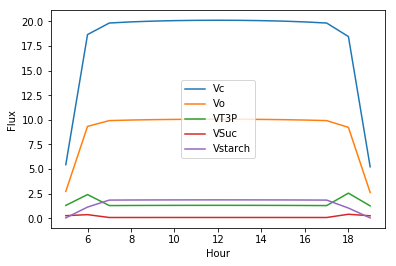

In [17]:
import matplotlib.pyplot as plt
#plt.plot(df270["Light intensity"])
plt.plot(df270["Hour"],df270["Vc"],label="Vc")
plt.plot(df270["Hour"],df270["Vo"],label="Vo")
plt.plot(df270["Hour"],df270["VT3P"],label="VT3P")
plt.plot(df270["Hour"],df270["VSuc"],label="VSuc")
plt.plot(df270["Hour"],df270["Vstarch"],label="Vstarch")
plt.xlabel("Hour")
plt.ylabel("Flux")
plt.legend(loc="center")
plt.show()

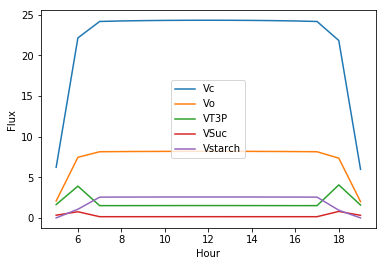

In [18]:
import matplotlib.pyplot as plt
#plt.plot(df400["Light intensity"])
plt.plot(df400["Hour"],df400["Vc"],label="Vc")
plt.plot(df400["Hour"],df400["Vo"],label="Vo")
plt.plot(df400["Hour"],df400["VT3P"],label="VT3P")
plt.plot(df400["Hour"],df400["VSuc"],label="VSuc")
plt.plot(df400["Hour"],df400["Vstarch"],label="Vstarch")
plt.xlabel("Hour")
plt.ylabel("Flux")
plt.legend(loc="center")
plt.show()

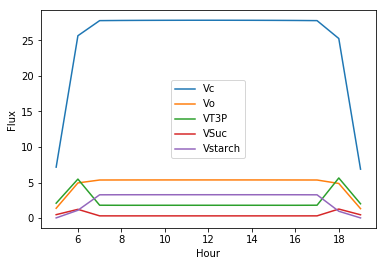

In [19]:
import matplotlib.pyplot as plt
#plt.plot(df700["Light intensity"])
plt.plot(df700["Hour"],df700["Vc"],label="Vc")
plt.plot(df700["Hour"],df700["Vo"],label="Vo")
plt.plot(df700["Hour"],df700["VT3P"],label="VT3P")
plt.plot(df700["Hour"],df700["VSuc"],label="VSuc")
plt.plot(df700["Hour"],df700["Vstarch"],label="Vstarch")
plt.xlabel("Hour")
plt.ylabel("Flux")
plt.legend(loc="center")
plt.show()